In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression, BayesianRidge
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
warnings.simplefilter(action='ignore')

In [2]:
pd.set_option('display.max_columns',500)
pd.set_option('display.max_rows',100)
np.random.seed(3)
%matplotlib inline
sns.set()

In [3]:
df = pd.read_csv('case 2 data/train.csv')
df.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,DisbursalDate,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-84,Salaried,03-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-85,Self employed,26-09-18,6,1998,1,1,0,0,0,0,598,I-Medium Risk,1,1,1,27600,50200,50200,0,0,0,0,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-85,Self employed,01-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-93,Self employed,26-10-18,6,1998,1,1,0,0,0,0,305,L-Very High Risk,3,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,539055,52378,60300,88.39,67,22807,45,1495,09-12-77,Self employed,26-09-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1


In [4]:
df.shape, df.isna().sum()[df.isna().sum() > 0]

((233154, 41), Employment.Type    7661
 dtype: int64)

In [5]:
df.describe()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,NO.OF_INQUIRIES,loan_default
count,233154.000000,233154.000000,2.331540e+05,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,233154.0,233154.00000,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,233154.000000,2.331540e+05,2.331540e+05,2.331540e+05,233154.000000,233154.000000,233154.000000,2.331540e+05,2.331540e+05,2.331540e+05,2.331540e+05,2.331540e+05,233154.000000,233154.000000,233154.000000,233154.000000
mean,535917.573376,54356.993528,7.586507e+04,74.746530,72.936094,19638.635035,69.028054,3396.880247,7.262243,1549.477148,1.0,0.84032,0.075577,0.144943,0.023242,0.002127,289.462994,2.440636,1.039896,0.156549,1.659001e+05,2.185039e+05,2.180659e+05,0.059081,0.027703,0.007244,5.427793e+03,7.295923e+03,7.179998e+03,1.310548e+04,3.232684e+02,0.381833,0.097481,0.206615,0.217071
std,68315.693711,12971.314171,1.894478e+04,11.456636,69.834995,3491.949566,22.141304,2238.147502,4.482230,975.261278,0.0,0.36631,0.264320,0.352044,0.150672,0.046074,338.374779,5.217233,1.941496,0.548787,9.422736e+05,2.374794e+06,2.377744e+06,0.626795,0.316057,0.111079,1.702370e+05,1.831560e+05,1.825925e+05,1.513679e+05,1.555369e+04,0.955107,0.384439,0.706498,0.412252
min,417428.000000,13320.000000,3.700000e+04,10.030000,1.000000,10524.000000,45.000000,1.000000,1.000000,1.000000,1.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.678296e+06,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,-5.746470e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,476786.250000,47145.000000,6.571700e+04,68.880000,14.000000,16535.000000,48.000000,1511.000000,4.000000,713.000000,1.0,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
50%,535978.500000,53803.000000,7.094600e+04,76.800000,61.000000,20333.000000,86.000000,2970.000000,6.000000,1451.000000,1.0,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
75%,595039.750000,60413.000000,7.920175e+04,83.670000,130.000000,23000.000000,86.000000,5677.000000,10.000000,2362.000000,1.0,1.00000,0.000000,0.000000,0.000000,0.000000,678.000000,3.000000,1.000000,0.000000,3.500650e+04,6.250000e+04,6.080000e+04,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.999000e+03,0.000000e+00,0.000000,0.000000,0.000000,0.000000
max,671084.000000,990572.000000,1.628992e+06,95.000000,261.000000,24803.000000,156.000000,7345.000000,22.000000,3795.000000,1.0,1.00000,1.000000,1.000000,1.000000,1.000000,890.000000,453.000000,144.000000,25.000000,9.652492e+07,1.000000e+09,1.000000e+09,52.000000,36.000000,8.000000,3.603285e+07,3.000000e+07,3.000000e+07,2.564281e+07,4.170901e+06,35.000000,20.000000,36.000000,1.000000


In [6]:
df.dtypes

UniqueID                                 int64
disbursed_amount                         int64
asset_cost                               int64
ltv                                    float64
branch_id                                int64
supplier_id                              int64
manufacturer_id                          int64
Current_pincode_ID                       int64
Date.of.Birth                           object
Employment.Type                         object
DisbursalDate                           object
State_ID                                 int64
Employee_code_ID                         int64
MobileNo_Avl_Flag                        int64
Aadhar_flag                              int64
PAN_flag                                 int64
VoterID_flag                             int64
Driving_flag                             int64
Passport_flag                            int64
PERFORM_CNS.SCORE                        int64
PERFORM_CNS.SCORE.DESCRIPTION           object
PRI.NO.OF.ACC

In [7]:
df.nunique()

UniqueID                               233154
disbursed_amount                        24565
asset_cost                              46252
ltv                                      6579
branch_id                                  82
supplier_id                              2953
manufacturer_id                            11
Current_pincode_ID                       6698
Date.of.Birth                           15433
Employment.Type                             2
DisbursalDate                              84
State_ID                                   22
Employee_code_ID                         3270
MobileNo_Avl_Flag                           1
Aadhar_flag                                 2
PAN_flag                                    2
VoterID_flag                                2
Driving_flag                                2
Passport_flag                               2
PERFORM_CNS.SCORE                         573
PERFORM_CNS.SCORE.DESCRIPTION              20
PRI.NO.OF.ACCTS                   

In [8]:
def reduce_mem_usage(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
                    
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [9]:
def getdatefeat(df,colname):
    df[colname] = pd.to_datetime(df[colname])
    df[colname+'.Year'] = df[colname].dt.year
    df[colname+'.Month'] = df[colname].dt.month
    df[colname+'.Day'] = df[colname].dt.day
    df[colname+'.WeekDay'] = df[colname].dt.weekday
    df[colname+'.IsMonthStart'] = df[colname].dt.is_month_start
    df[colname+'.IsMonthEnd'] = df[colname].dt.is_month_end
    return df

In [10]:
def texttimetoint(df,colname):
    df[colname] = df[colname].apply(lambda x: int(x.split(' ')[0].split('y')[0])*12 + int(x.split(' ')[1].split('m')[0]))
    return df

In [11]:
def removestaticcols(df):
    for colname in df.columns:
        if df[colname].nunique() == 1:
            df.drop(colname, axis = 1, inplace= True)


In [12]:
"""
For Feature engineering, I create 3 types of features:
1. Features dependent on the business sense. These features, I create with the help of the non-technical team and 
research on internet based on the data and business and the problem statement.
2. Features based on the raw data. These features are generally created to capture indirect information in the data using groupby, 
unique, sum,count etc.
3. Features to capture anomalies in the data. 
    (1) Search EDA for things that look weird. 
    (2) Verify weirdness by comparing to randomly generated data (with same distribution type) 
    and confirm that those weird things are in test data 
    (3) Create new features to capture what you see 
    (4) Add to model and tune your model hyperparameters. 
    (5) Confirm CV increases
"""
def processdata(df):
    df = getdatefeat(df,'Date.of.Birth')
    df = getdatefeat(df,'DisbursalDate')
    df = texttimetoint(df,'AVERAGE.ACCT.AGE')
    df = texttimetoint(df,'CREDIT.HISTORY.LENGTH')
    df.fillna('Null', inplace = True)
    df['Employment.Type'] = df['Employment.Type'].map({'Salaried': 1 ,'Self employed': 2 , 'Null': 3})
    removestaticcols(df)
    df.drop_duplicates(keep='first', inplace = True)
    df = reduce_mem_usage(df)
    return df

In [13]:
df = processdata(df)
df.dtypes

Memory usage after optimization is: 27.57 MB
Decreased by 68.0%


UniqueID                                        int32
disbursed_amount                                int32
asset_cost                                      int32
ltv                                           float16
branch_id                                       int16
supplier_id                                     int16
manufacturer_id                                 int16
Current_pincode_ID                              int16
Date.of.Birth                          datetime64[ns]
Employment.Type                                  int8
DisbursalDate                          datetime64[ns]
State_ID                                         int8
Employee_code_ID                                int16
Aadhar_flag                                      int8
PAN_flag                                         int8
VoterID_flag                                     int8
Driving_flag                                     int8
Passport_flag                                    int8
PERFORM_CNS.SCORE           

(<matplotlib.axes._subplots.AxesSubplot at 0x212547c43c8>, 0.2170711203753742)

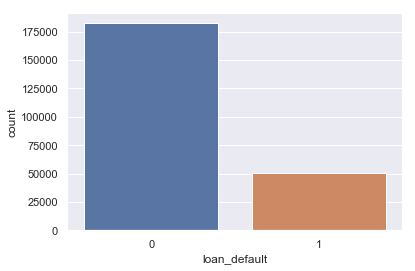

In [14]:
sns.countplot(x='loan_default', data=df), df.loan_default.sum()/df.shape[0]

In [15]:
df.corr()['loan_default']

UniqueID                               0.033848
disbursed_amount                       0.077675
asset_cost                             0.014261
ltv                                    0.098208
branch_id                              0.030193
supplier_id                            0.027357
manufacturer_id                       -0.025039
Current_pincode_ID                     0.028419
Employment.Type                        0.024823
State_ID                               0.048075
Employee_code_ID                       0.020657
Aadhar_flag                           -0.041593
PAN_flag                               0.002046
VoterID_flag                           0.043747
Driving_flag                          -0.005821
Passport_flag                         -0.007602
PERFORM_CNS.SCORE                     -0.057929
PRI.NO.OF.ACCTS                       -0.035456
PRI.ACTIVE.ACCTS                      -0.041451
PRI.OVERDUE.ACCTS                      0.040872
PRI.CURRENT.BALANCE                   -0

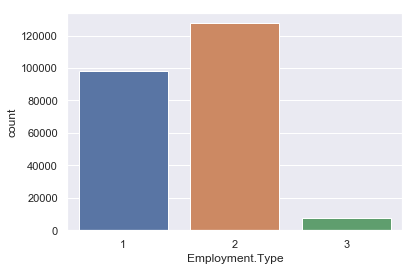

In [16]:
sns.countplot(x='Employment.Type', data=df)

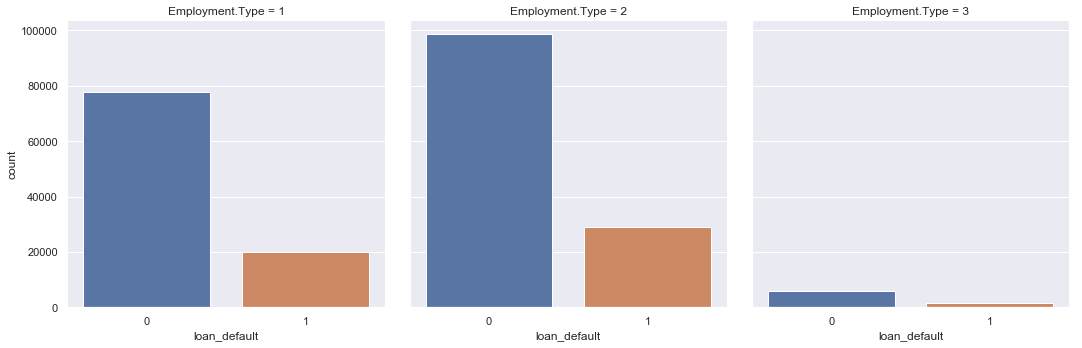

In [17]:
sns.catplot(x='loan_default', col='Employment.Type', kind='count', data=df)

(<matplotlib.axes._subplots.AxesSubplot at 0x212547a4b38>, 0.8403201317584086)

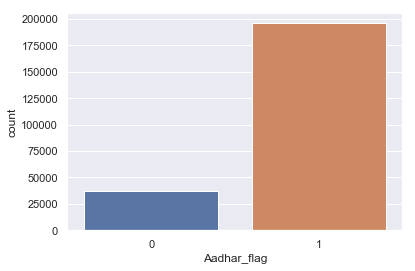

In [18]:
sns.countplot(x='Aadhar_flag', data=df), df.Aadhar_flag.sum()/df.shape[0]

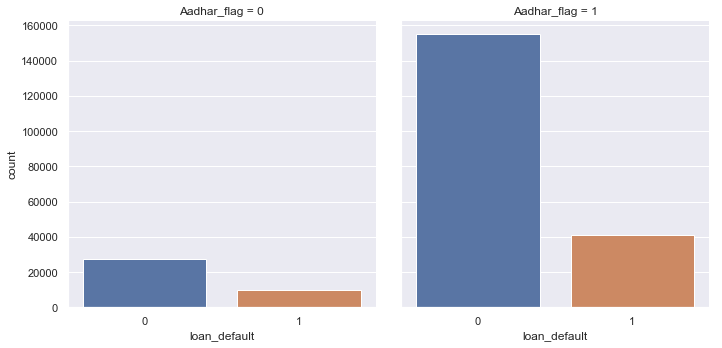

In [19]:
sns.catplot(x='loan_default', col='Aadhar_flag', kind='count', data=df)

(<matplotlib.axes._subplots.AxesSubplot at 0x21254a532b0>, 0.07557665748818378)

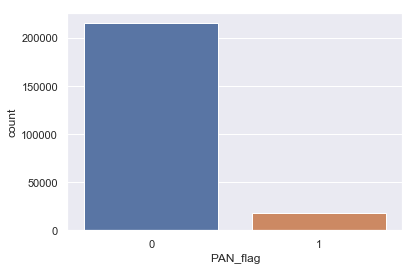

In [20]:
sns.countplot(x='PAN_flag', data=df), df.PAN_flag.sum()/df.shape[0]

In [21]:
pd.crosstab(df.PAN_flag, df.loan_default, margins=True).style.background_gradient(cmap='autumn_r')

loan_default,0,1,All
PAN_flag,,,
0,168799,46734,215533
1,13744,3877,17621
All,182543,50611,233154


(<matplotlib.axes._subplots.AxesSubplot at 0x212554b85c0>, 0.14494282748741175)

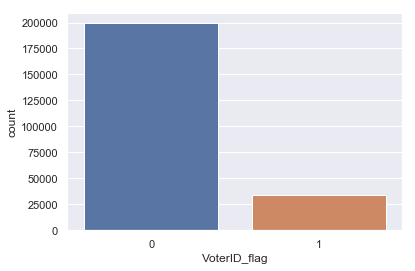

In [22]:
sns.countplot(x='VoterID_flag', data=df), df.VoterID_flag.sum()/df.shape[0]

(<matplotlib.axes._subplots.AxesSubplot at 0x21255518278>,
 0.023242148965919522)

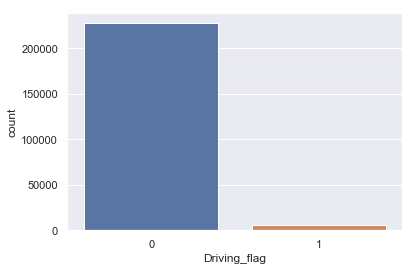

In [23]:
sns.countplot(x='Driving_flag', data=df), df.Driving_flag.sum()/df.shape[0]

(<matplotlib.axes._subplots.AxesSubplot at 0x21255a8a5c0>,
 0.0021273493056091683)

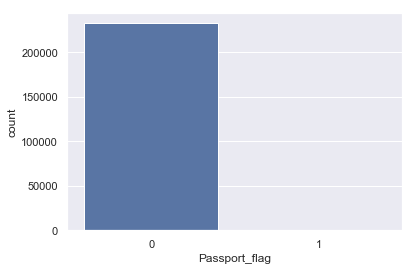

In [24]:
sns.countplot(x='Passport_flag', data=df), df.Passport_flag.sum()/df.shape[0]

(<matplotlib.axes._subplots.AxesSubplot at 0x21255ae02e8>,
 0.007244139066882833)

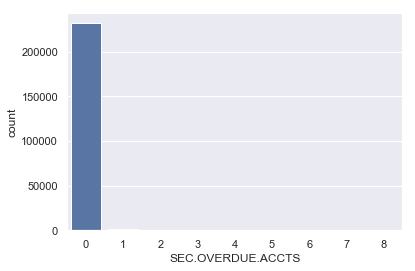

In [25]:
sns.countplot(x='SEC.OVERDUE.ACCTS', data=df), df['SEC.OVERDUE.ACCTS'].sum()/df.shape[0]

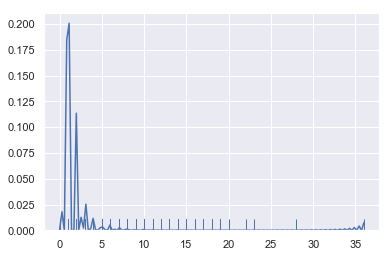

In [26]:
sns.distplot(df[['NO.OF_INQUIRIES']], hist=False, rug=True)

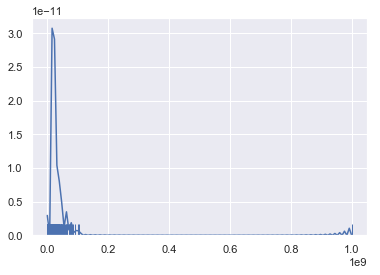

In [27]:
sns.distplot(df[['PRI.DISBURSED.AMOUNT']], hist=False, rug=True)

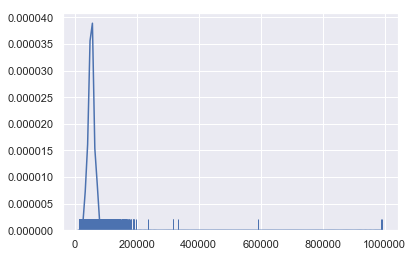

In [28]:
sns.distplot(df[['disbursed_amount']], hist=False, rug=True)

In [29]:
def plot_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(2,4,figsize=(18,8))

    for feature in features:
        i += 1
        plt.subplot(2,4,i)
        sns.kdeplot(df1[feature], bw=0.5,label=label1)
        sns.kdeplot(df2[feature], bw=0.5,label=label2)
        plt.xlabel(feature, fontsize=11)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=8)
        plt.tick_params(axis='y', which='major', labelsize=8)
    plt.show();

<Figure size 432x288 with 0 Axes>

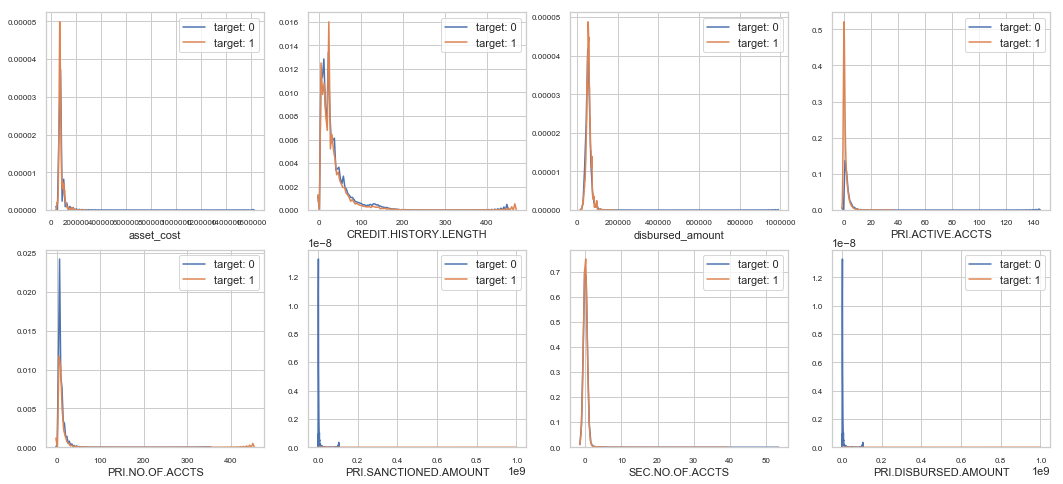

In [30]:
t0 = df.loc[df['loan_default'] == 0]
t1 = df.loc[df['loan_default'] == 1]
features = ['asset_cost','CREDIT.HISTORY.LENGTH','disbursed_amount','PRI.ACTIVE.ACCTS','PRI.NO.OF.ACCTS','PRI.SANCTIONED.AMOUNT'
           ,'SEC.NO.OF.ACCTS','PRI.DISBURSED.AMOUNT']
plot_feature_distribution(t0, t1, 'target: 0', 'target: 1', features)

In [31]:
tmp = pd.melt(df.corr().reset_index(), id_vars = ['index'], value_vars = df.columns)
tmp = tmp[tmp.value != 1.0]
tmp[tmp.value > 0.5], tmp[tmp.value < -0.5]

(                             index                      variable     value
 43             DisbursalDate.Month                      UniqueID  0.533328
 49                      asset_cost              disbursed_amount  0.752668
 95                disbursed_amount                    asset_cost  0.752668
 958               PRI.ACTIVE.ACCTS               PRI.NO.OF.ACCTS  0.753565
 971   NEW.ACCTS.IN.LAST.SIX.MONTHS               PRI.NO.OF.ACCTS  0.537622
 1004               PRI.NO.OF.ACCTS              PRI.ACTIVE.ACCTS  0.753565
 1018  NEW.ACCTS.IN.LAST.SIX.MONTHS              PRI.ACTIVE.ACCTS  0.702943
 1021         CREDIT.HISTORY.LENGTH              PRI.ACTIVE.ACCTS  0.506247
 1150          PRI.DISBURSED.AMOUNT         PRI.SANCTIONED.AMOUNT  0.998747
 1196         PRI.SANCTIONED.AMOUNT          PRI.DISBURSED.AMOUNT  0.998747
 1246              SEC.ACTIVE.ACCTS               SEC.NO.OF.ACCTS  0.828727
 1247             SEC.OVERDUE.ACCTS               SEC.NO.OF.ACCTS  0.510394
 1292       

In [32]:
random_state = 2103

In [33]:
"""
I usually tune the depth/leaves first, then featurefraction and baggingfraction, then mindata/minhessianinleaf 
using a few standard values (0.3, 0.7, 0.9 fractions), (31, 71, 123, 171 leaves). Then once I have a general tuning I 
fine tune from there. Here, since I had limited time I was unable to fine tune them. For tuning I generally use optuna library.
"""
lgb_params = {
    "objective" : "binary",
    "metric" : "auc",
    "boosting": 'gbdt',
    "max_depth" : -1,
    "num_leaves" : 16,
    "learning_rate" : 0.03,
    #"bagging_freq": 5,
    #"bagging_fraction" : 0.4,
    #"feature_fraction" : 0.05,
    #"min_data_in_leaf": 80,
    #"min_sum_heassian_in_leaf": 10,
    #"tree_learner": "serial",
    #"boost_from_average": "false",
    #"bagging_seed" : random_state,
    "verbosity" : 1,
    "seed": random_state
} #0.673

In [34]:
noreq = ['UniqueID','loan_default','PERFORM_CNS.SCORE.DESCRIPTION','Date.of.Birth','DisbursalDate']
traincols = [colname for colname in df.columns if colname not in noreq]
X = df[traincols]
y = df['loan_default']

In [35]:
skf = StratifiedKFold(n_splits=5, random_state = random_state, shuffle = True)
oof_log = np.zeros(len(y))
oof_dec = np.zeros(len(y))
oof_rf = np.zeros(len(y))
oof_lgb = np.zeros(len(y))
feature_importance_df = pd.DataFrame()
n =1
for train_index, test_index in skf.split(X, y):
    print('Fold: ', n)
    n+=1
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    print('Training Logistic Regression')
    log_clf = LogisticRegression(random_state=random_state,class_weight = {0: sum(y_train)/len(y_train),1: 1 - sum(y_train)/len(y_train) }).fit(X_train, y_train) 
    oof_log[test_index] = log_clf.predict_proba(X_test)[:,1]
    print('ROC LOG Score:',roc_auc_score(y_test,oof_log[test_index]))
    print('Descision Tree')
    dec_clf = DecisionTreeClassifier(criterion = 'entropy',random_state=random_state,class_weight = {0: sum(y_train)/len(y_train),1: 1 - sum(y_train)/len(y_train) }).fit(X_train, y_train) #0.5448,0.6003
    oof_dec[test_index] = dec_clf.predict_proba(X_test)[:,1]
    print('ROC DEC Score:',roc_auc_score(y_test,oof_dec[test_index]))
    print('Random Forest')
    rf_clf = RandomForestClassifier(n_estimators=100, max_depth=5,criterion = 'entropy',random_state=random_state,class_weight = {0: sum(y_train)/len(y_train),1: 1 - sum(y_train)/len(y_train) }).fit(X_train, y_train) #0.5448,0.6003
    oof_rf[test_index] = rf_clf.predict_proba(X_test)[:,1]
    print('ROC RF Score:',roc_auc_score(y_test,oof_rf[test_index]))
    trn_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_test, label=y_test)
    lgb_clf = lgb.train(lgb_params,trn_data,100000,valid_sets = [trn_data, val_data],early_stopping_rounds=1000,verbose_eval = 1000)
    oof_lgb[test_index] = lgb_clf.predict(X_test)
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = traincols
    fold_importance_df["importance"] = lgb_clf.feature_importance()
    fold_importance_df["fold"] = n
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)    
print('ROC LOG Score:',roc_auc_score(y,oof_log))#0.5448,0.6003
print('ROC DEC Score:',roc_auc_score(y,oof_dec))#0.5263,0.5287
print('ROC RF Score:',roc_auc_score(y,oof_rf))#0.6379
print('ROC LGB Score:',roc_auc_score(y,oof_lgb))#0.6379

Fold:  1
Training Logistic Regression
ROC LOG Score: 0.5866659691913976
Descision Tree
ROC DEC Score: 0.5281754218234724
Random Forest
ROC RF Score: 0.6382406355536939
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.715199	valid_1's auc: 0.672209
[2000]	training's auc: 0.749411	valid_1's auc: 0.67377
[3000]	training's auc: 0.777817	valid_1's auc: 0.673063
Early stopping, best iteration is:
[2266]	training's auc: 0.757525	valid_1's auc: 0.67391
Fold:  2
Training Logistic Regression
ROC LOG Score: 0.6080704473867691
Descision Tree
ROC DEC Score: 0.5244234288921048
Random Forest
ROC RF Score: 0.6421738171015249
Training until validation scores don't improve for 1000 rounds.
[1000]	training's auc: 0.715168	valid_1's auc: 0.672369
[2000]	training's auc: 0.749859	valid_1's auc: 0.672302
Early stopping, best iteration is:
[1458]	training's auc: 0.731889	valid_1's auc: 0.672643
Fold:  3
Training Logistic Regression
ROC LOG Score: 0.6116139108247913
Desc